In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from google.colab import drive
import os
import zipfile
import shutil
import math

drive.mount('/content/drive')

kaggle_json_path = '/content/drive/MyDrive/kaggle.json'

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

!cp '{kaggle_json_path}' ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

with zipfile.ZipFile("/content/cards-image-datasetclassification.zip","r") as zip_ref:
    zip_ref.extractall("cards-image-dataset")

shutil.rmtree('/content/cards-image-dataset/train/joker', ignore_errors=True)
shutil.rmtree('/content/cards-image-dataset/valid/joker', ignore_errors=True)
shutil.rmtree('/content/cards-image-dataset/test/joker', ignore_errors=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
cards-image-datasetclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [63]:
#import shutil
#shutil.rmtree('/content/cards-image-dataset/', ignore_errors=True)

In [64]:
import json

def get_dataset_info():
  dataset_basepath = './cards-image-dataset/'

  dataset_info = {"train_total": 0, "valid_total": 0, "test_total": 0, "train": [], "valid": [], "test": []}

  for i, _set in enumerate(['train', 'valid', 'test']):
    set_path = dataset_basepath + _set
    train_dir = os.listdir(set_path)
    print(f"Number of directories in {_set}: ", len(train_dir))

    dir_images_count = 0
    for dirname in train_dir:
      images_count = len(os.listdir(set_path + '/' + dirname))
      dir_images_count += images_count
      dataset_info[_set].append({"label": dirname, "qtd": images_count})

    dataset_info[_set + "_total"] = dir_images_count

  df_train = pd.DataFrame(dataset_info['train'])
  df_valid = pd.DataFrame(dataset_info['valid'])
  df_test = pd.DataFrame(dataset_info['test'])

  df_train['set'] = 'train'
  df_valid['set'] = 'valid'
  df_test['set'] = 'test'
  df = pd.concat([df_train, df_valid, df_test])
  df_summary = df.groupby(['label', 'set']).agg({'qtd': 'sum'}).reset_index()

  with open('dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=4)

  return dataset_info, df_summary

In [65]:
def plot_dataset_pie(dataset_info):
  dataset_sizes = [dataset_info['train_total'], dataset_info['valid_total'], dataset_info['test_total']]
  labels = ['Train', 'Validation', 'Test']
  total_images = sum(dataset_sizes)

  def autopct_format(pct):
      absolute = int(np.round(pct / 100. * total_images))
      return f'{pct:.2f}%\n({absolute})'

  plt.figure(figsize=(20, 10))
  plt.pie(dataset_sizes,
          labels=labels,
          autopct=autopct_format,
          startangle=90,
          colors=['skyblue', 'lightgreen', 'salmon'],
          labeldistance=None)
  plt.legend(loc='best')
  plt.axis('equal')
  plt.title(f'Distribuição do Dataset entre Conjuntos (Total: {total_images} imagens)')
  plt.show()

def plot_dataset_classes(df_summary, df_set, title):
  plt.figure(figsize=(20, 10))
  sns.barplot(data=df_summary[df_summary['set'] == df_set], x='label', y='qtd')
  plt.title(title)
  plt.xticks(rotation=90)
  plt.show()

In [66]:


def dataset_sample():
  dataset_basepath = './cards-image-dataset/'

  fig, ax = plt.subplots(6, 5, figsize=(20,20))
  ax = ax.ravel()

  plt.subplots_adjust(wspace=0.1, hspace=0.4, top=0.919)

  contfigs = 0

  for i, _set in enumerate(['train', 'valid', 'test']):
    set_path = dataset_basepath + _set
    dirnames = os.listdir(set_path)

    for cont in range(0, 2):
      cardtype = dirnames[random.randint(0, len(dirnames) -1)]
      cardtype_path = set_path + '/' + cardtype
      cardtype_images = os.listdir(cardtype_path)

      for c in range(0, 5):
        if len(cardtype_images) <= c:
          break

        idx = random.randint(0, len(cardtype_images) -1) if _set == "train" else c

        ax[contfigs].imshow(plt.imread(cardtype_path + '/' + cardtype_images[idx]))
        ax[contfigs].set_title(f'Set: {_set} Label: {cardtype}', fontsize=10)

        ax[contfigs].axis('off')
        contfigs += 1

  plt.suptitle('Amostra das Imagens de Treino, Validação e Teste', fontsize=16)

  plt.show()

In [67]:
import os
import random
import shutil

def split_dataset(dataset_path, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15, seed=27):
    random.seed(seed)

    dataset_basepath = './cards-image-dataset/'

    # Mover imagens das pastas valid e test para a pasta train
    for _set in ['valid', 'test']:
        set_path = dataset_basepath + _set
        for dirname in os.listdir(set_path):
            dir_path = os.path.join(set_path, dirname)
            if os.path.isdir(dir_path):
                train_dir_path = os.path.join(dataset_basepath + 'train', dirname)
                for filename in os.listdir(dir_path):
                    src_file_path = os.path.join(dir_path, filename)
                    dest_file_path = os.path.join(train_dir_path, filename)

                    if not os.path.exists(train_dir_path):
                        os.makedirs(train_dir_path)

                    shutil.move(src_file_path, dest_file_path)

    # Calcular o número mínimo de imagens entre as classes
    class_image_counts = {}
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            class_image_counts[class_dir] = len(os.listdir(class_path))

    min_images = min(class_image_counts.values()) if class_image_counts else 0
    max_images_per_class = min_images + 30

    # Criar diretórios para valid e test
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)

            # Limitar o número de imagens por classe
            if len(image_files) > max_images_per_class:
                excess_images = len(image_files) - max_images_per_class
                image_files = random.sample(image_files, max_images_per_class)

                # Excluir imagens excedentes no diretório de treino
                excess_train_images = os.listdir(class_path)
                excess_train_images = [img for img in excess_train_images if img not in image_files]
                for image_file in excess_train_images[:excess_images]:
                    src_path = os.path.join(class_path, image_file)
                    os.remove(src_path)  # Remove as imagens excedentes

            random.shuffle(image_files)

            num_images = len(image_files)
            num_train = int(train_ratio * num_images)
            num_validation = int(validation_ratio * num_images)
            num_test = num_images - num_train - num_validation

            train_images = image_files[:num_train]
            validation_images = image_files[num_train:num_train + num_validation]
            test_images = image_files[num_train + num_validation:]

            valid_class_path = os.path.join('./cards-image-dataset/valid', class_dir)
            test_class_path = os.path.join('./cards-image-dataset/test', class_dir)

            os.makedirs(valid_class_path, exist_ok=True)
            os.makedirs(test_class_path, exist_ok=True)

            # Mover imagens para a pasta de validação
            for image_file in validation_images:
                src_path = os.path.join(class_path, image_file)
                dest_path = os.path.join(valid_class_path, image_file)
                shutil.move(src_path, dest_path)

            # Mover imagens para a pasta de teste
            for image_file in test_images:
                src_path = os.path.join(class_path, image_file)
                dest_path = os.path.join(test_class_path, image_file)
                shutil.move(src_path, dest_path)

In [68]:
dataset_info, df_summary = get_dataset_info()

Number of directories in train:  52
Number of directories in valid:  52
Number of directories in test:  52


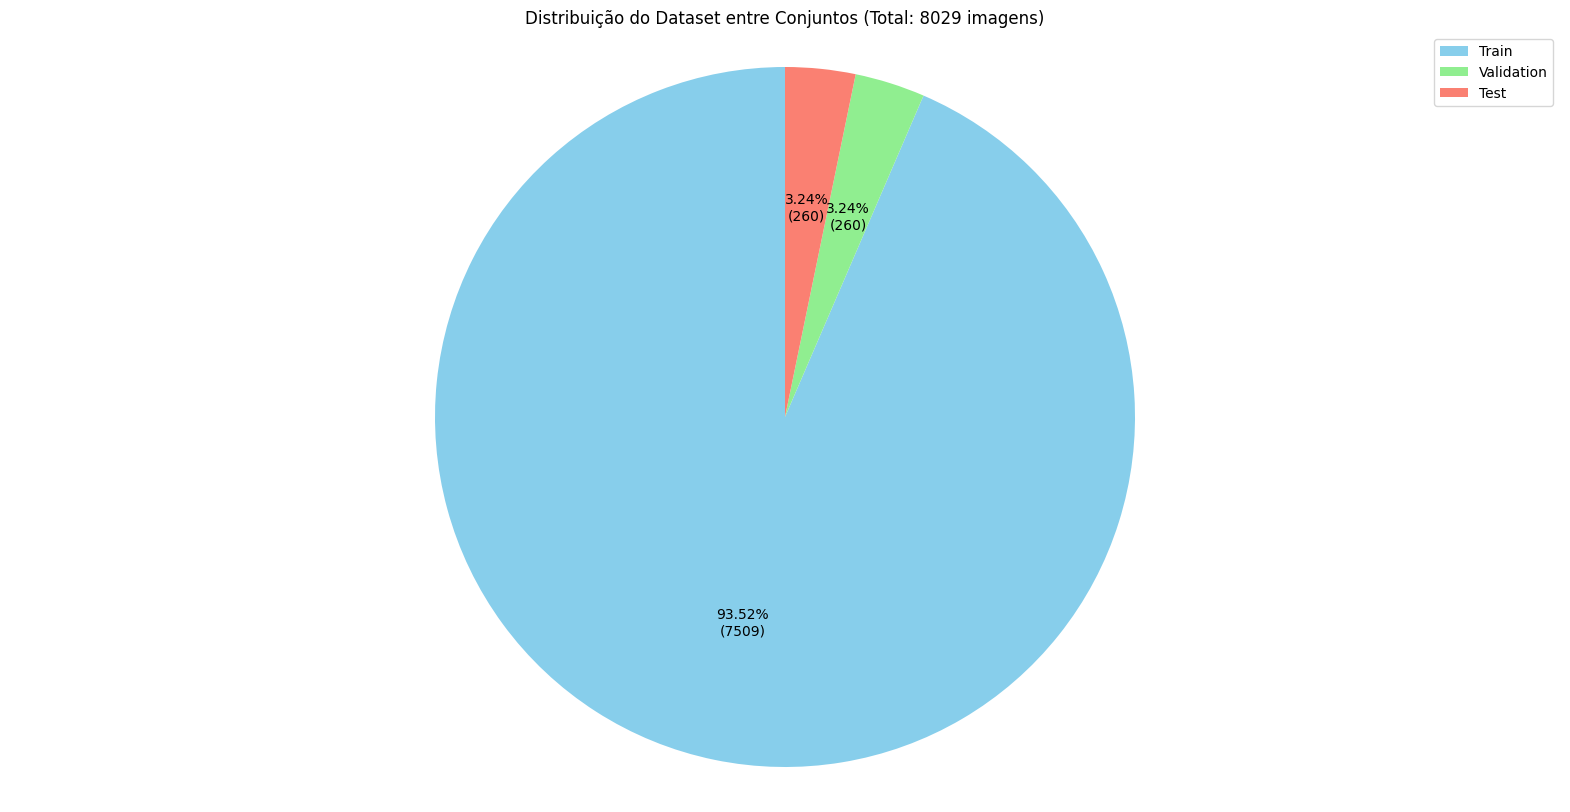

In [69]:
plot_dataset_pie(dataset_info)

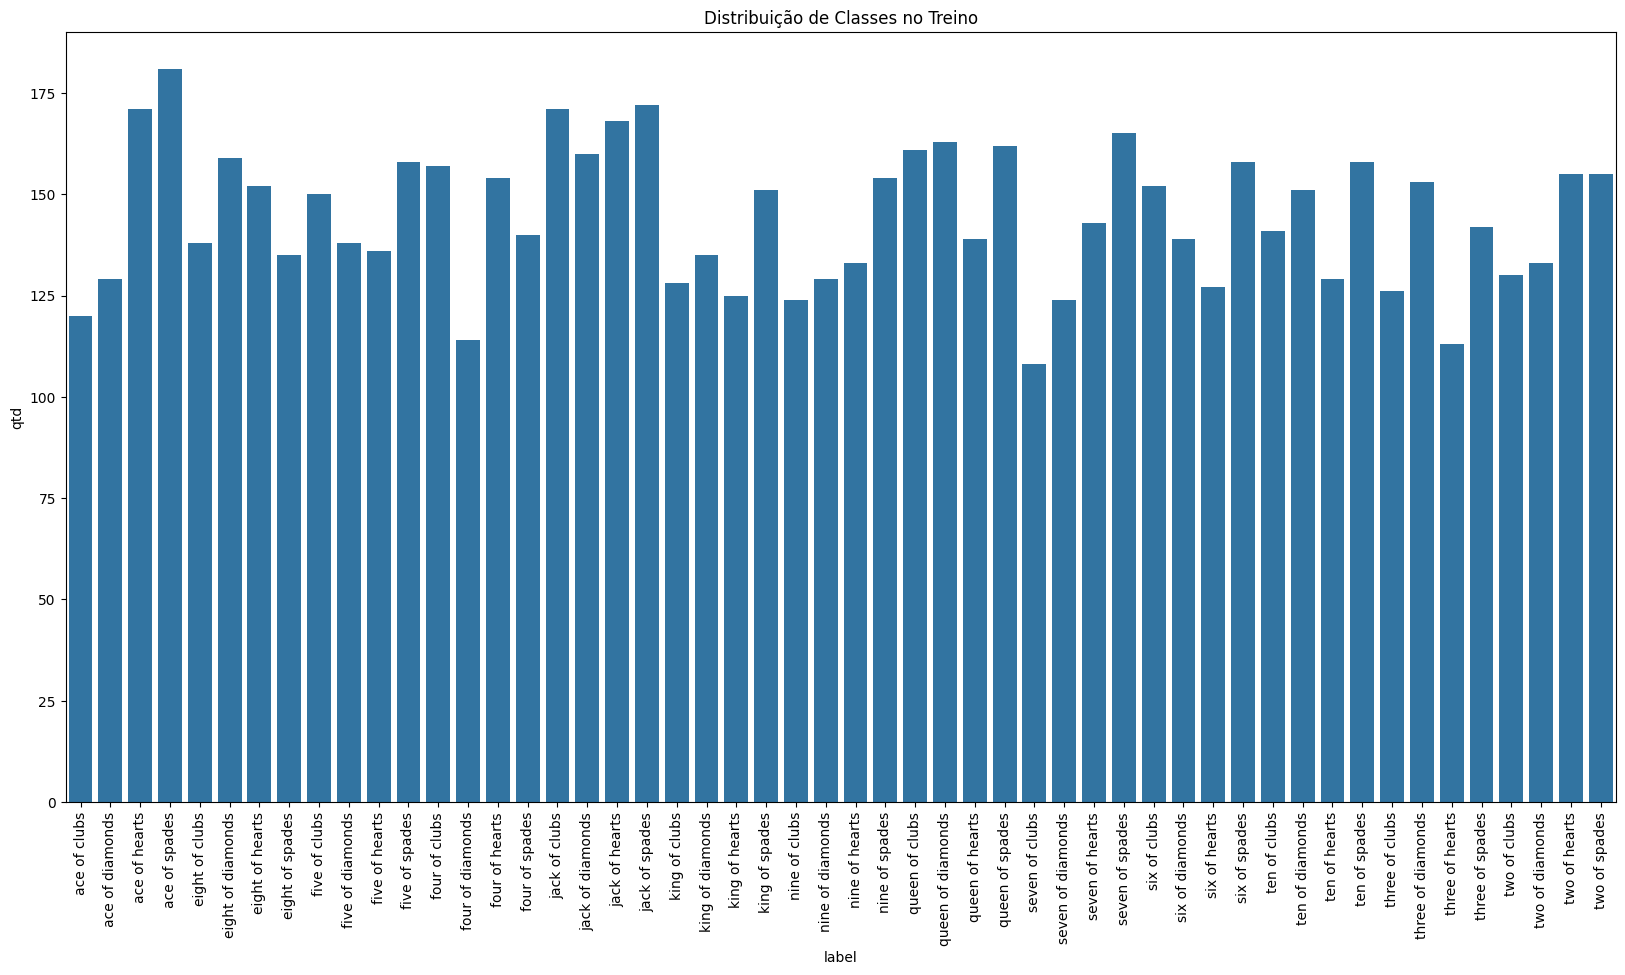

In [70]:
plot_dataset_classes(df_summary, "train", 'Distribuição de Classes no Treino')

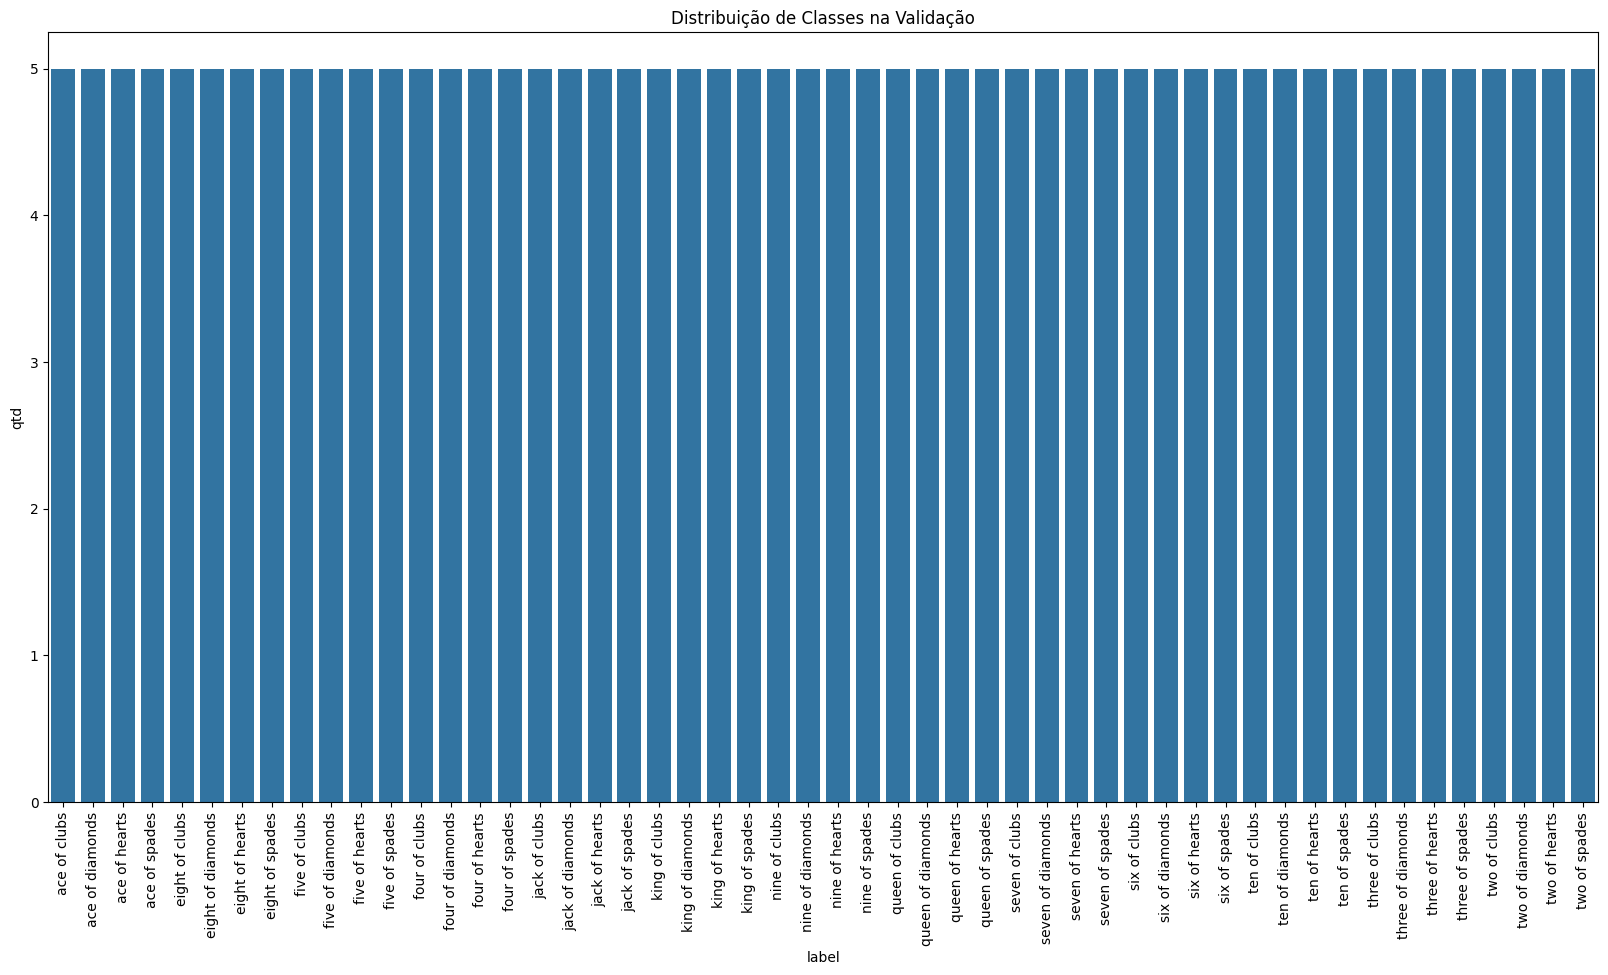

In [71]:
plot_dataset_classes(df_summary, "valid", 'Distribuição de Classes na Validação')

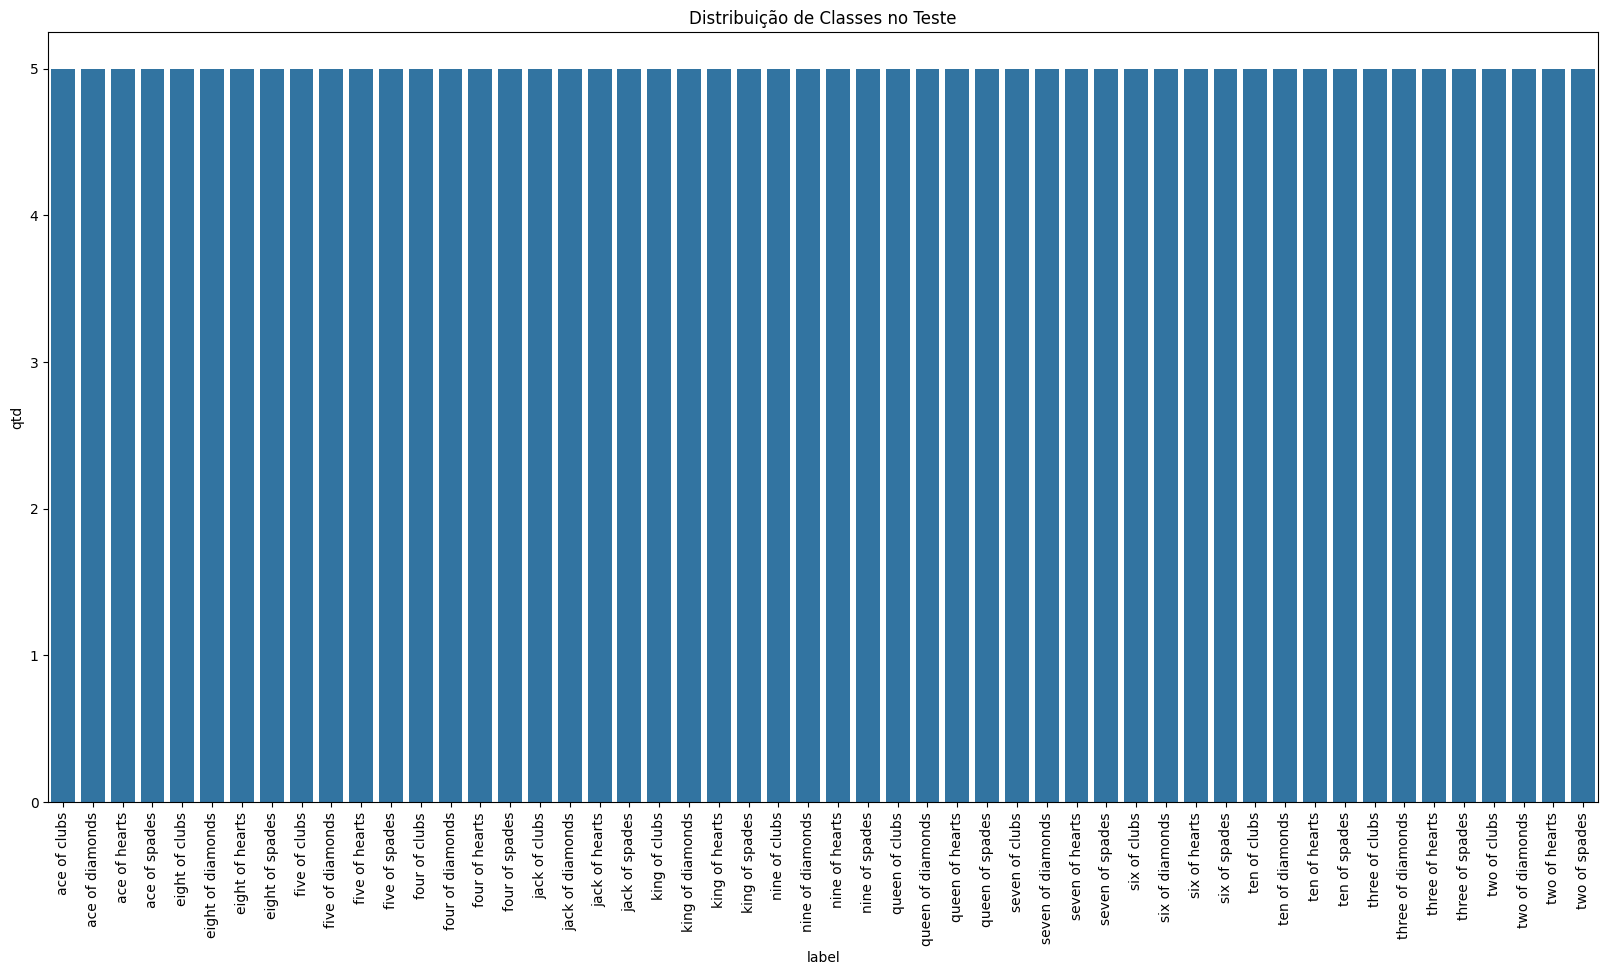

In [72]:
plot_dataset_classes(df_summary, "test", 'Distribuição de Classes no Teste')

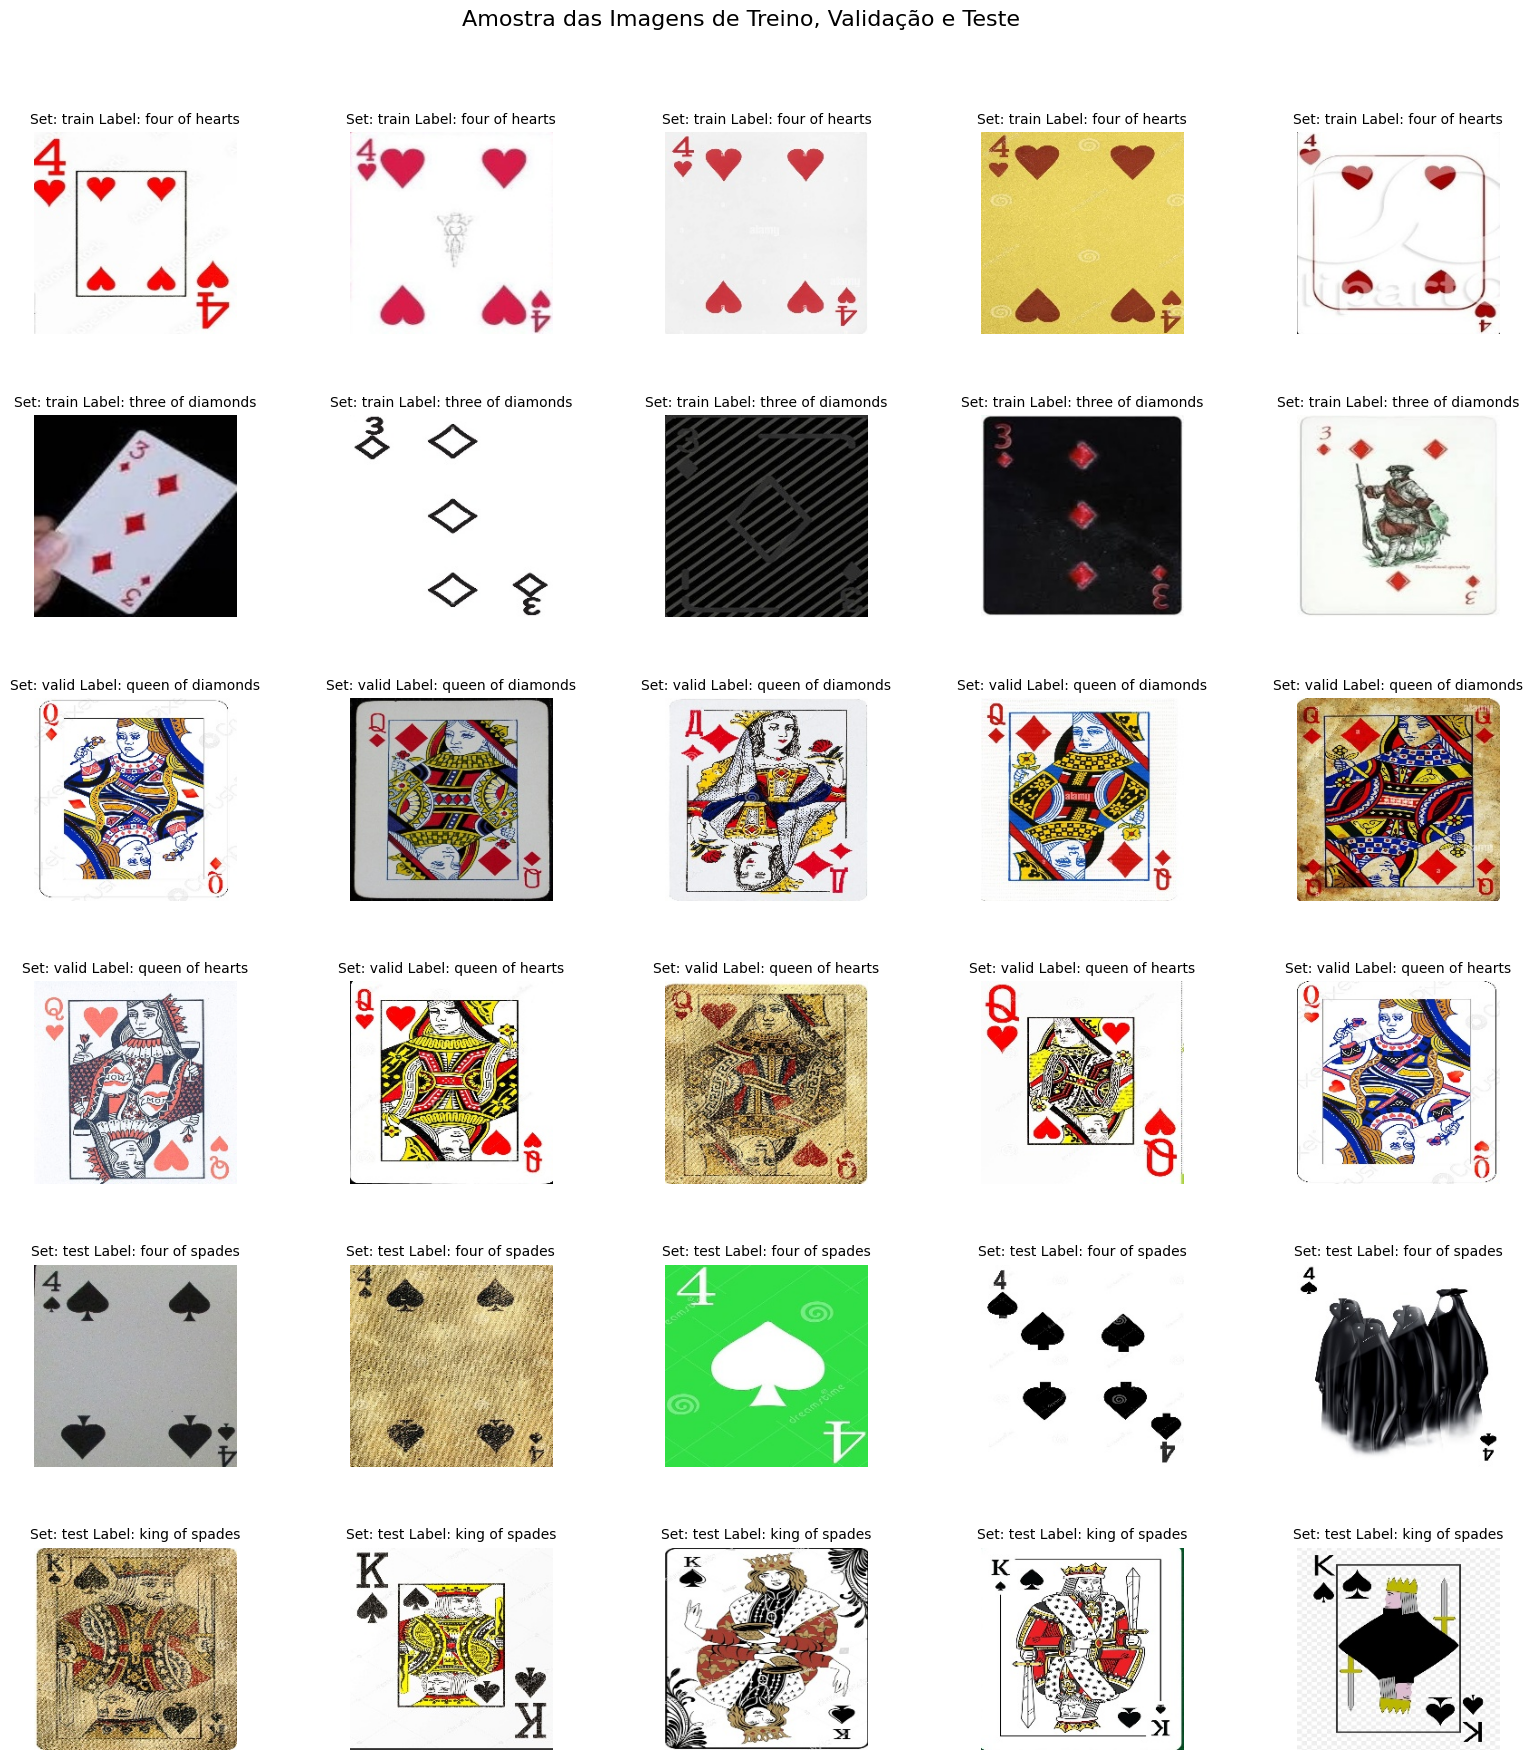

In [73]:
dataset_sample()

In [74]:
dataset_path = './cards-image-dataset/train'
split_dataset(dataset_path)

Number of directories in train:  52
Number of directories in valid:  52
Number of directories in test:  52


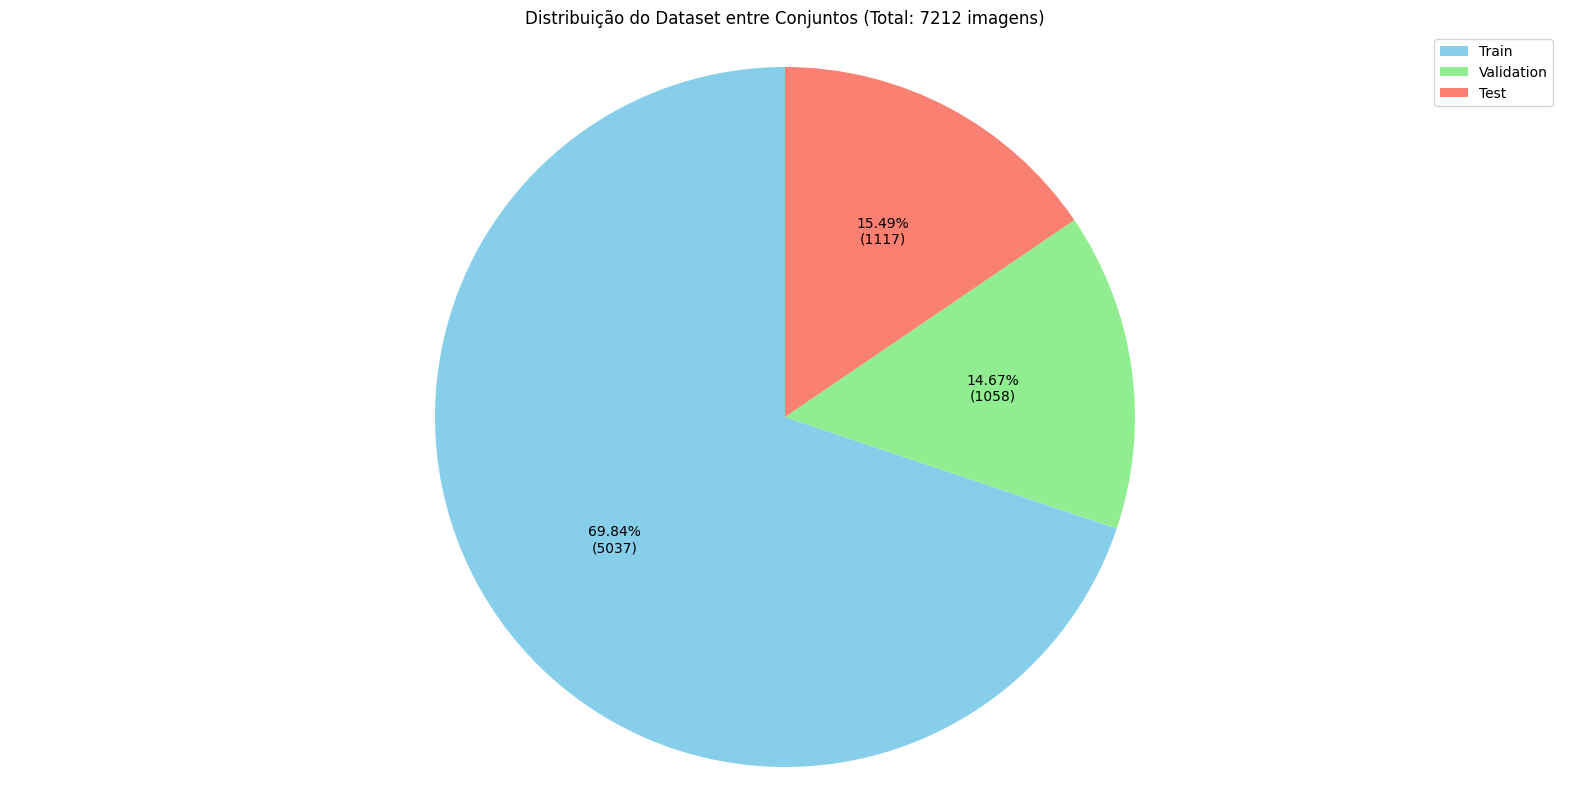

In [75]:
dataset_info, df_summary = get_dataset_info()
plot_dataset_pie(dataset_info)

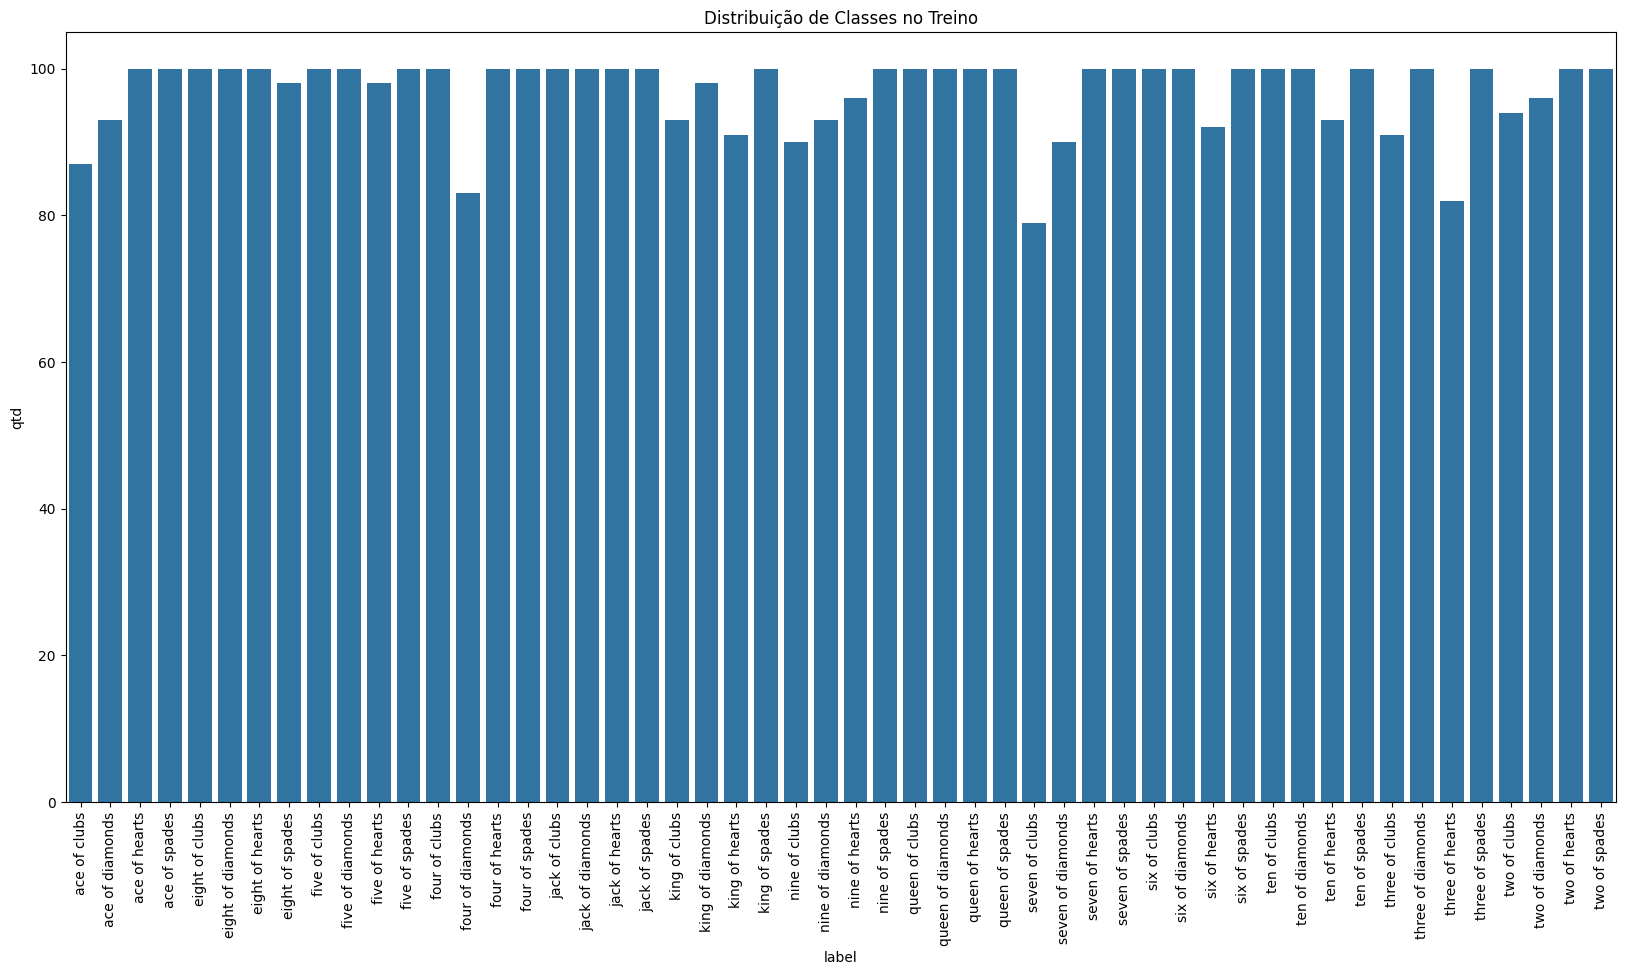

In [76]:
plot_dataset_classes(df_summary, "train", 'Distribuição de Classes no Treino')

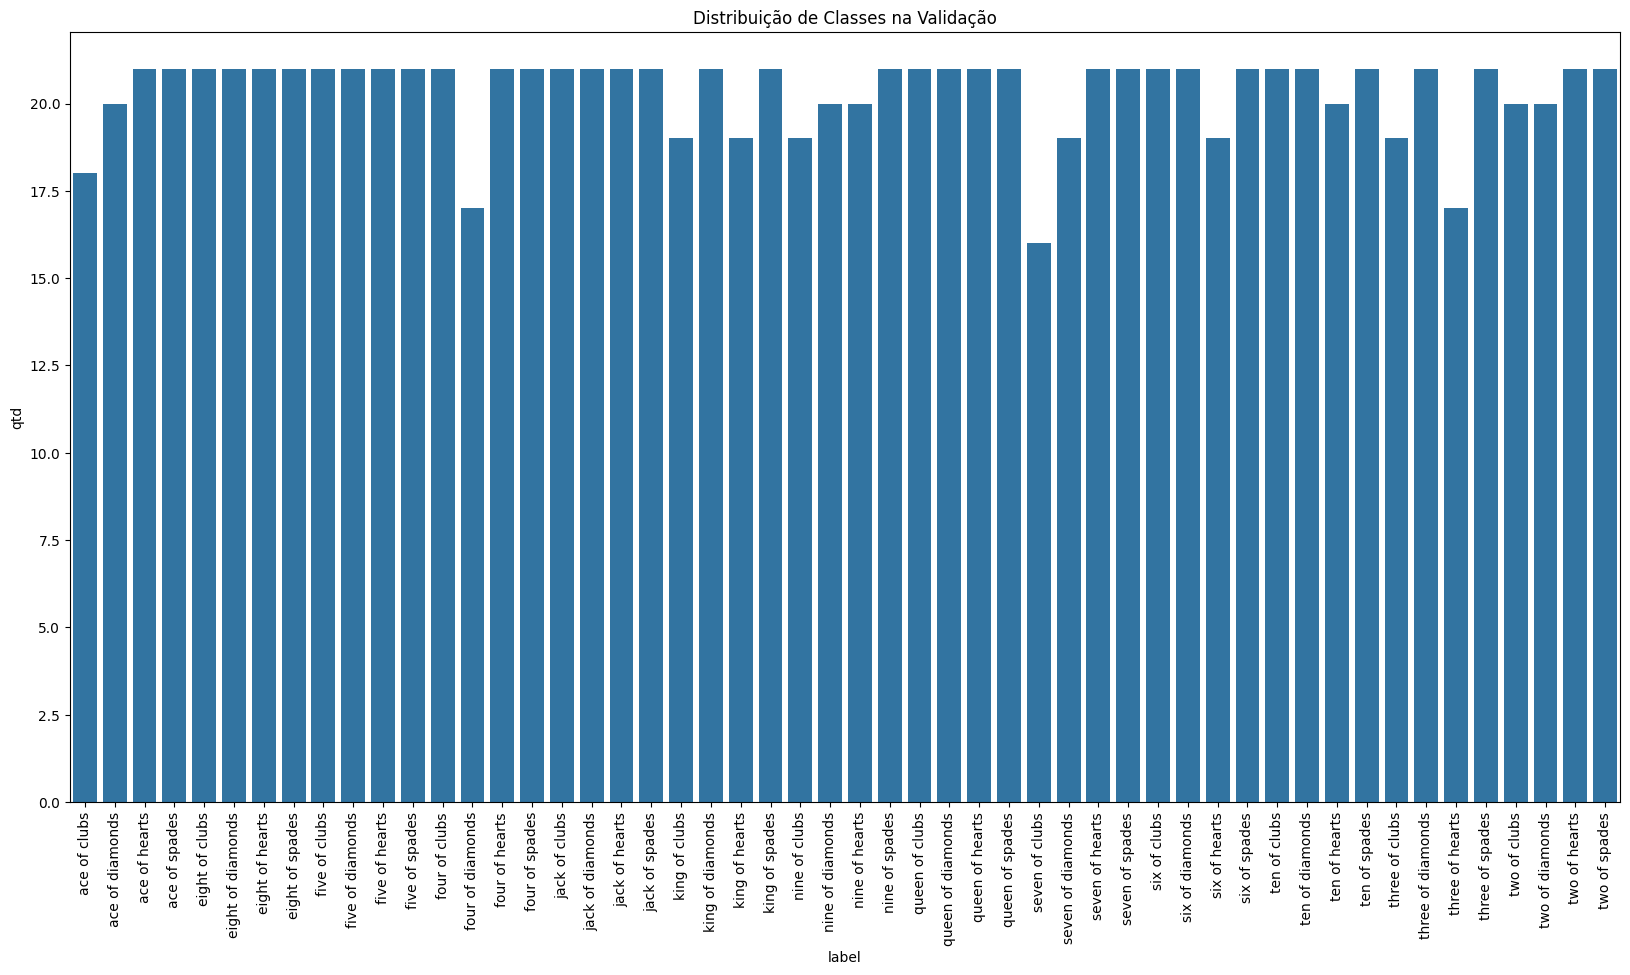

In [77]:
plot_dataset_classes(df_summary, "valid", 'Distribuição de Classes na Validação')

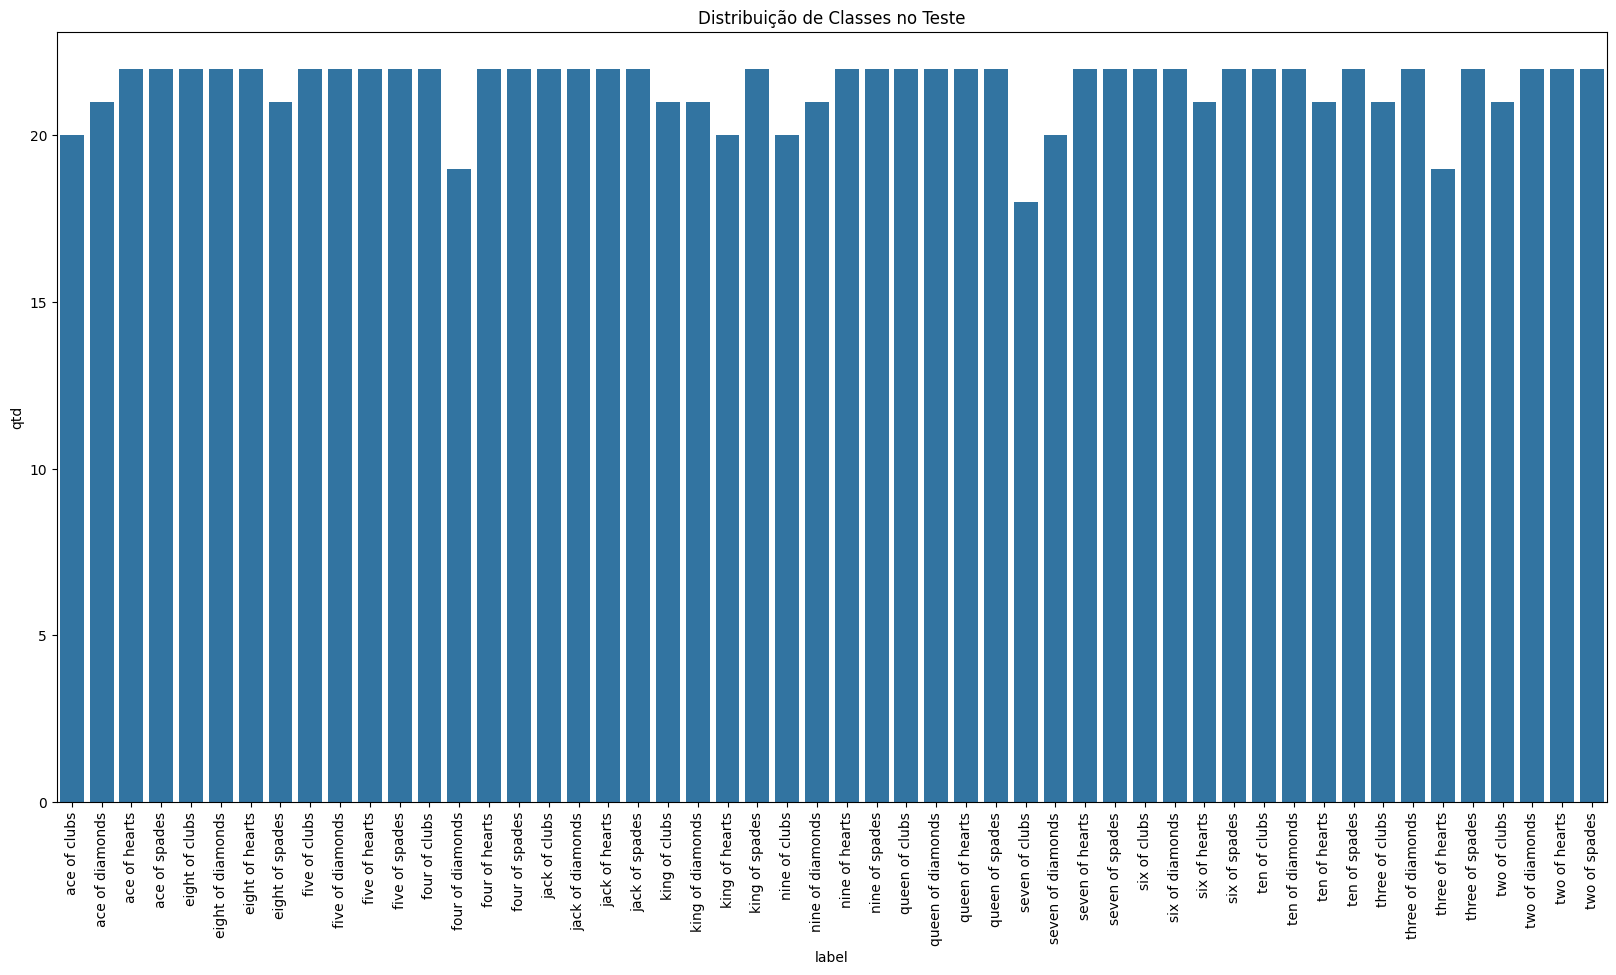

In [78]:
plot_dataset_classes(df_summary, "test", 'Distribuição de Classes no Teste')

In [79]:
destination_path = '/content/drive/MyDrive/Cartas/cards-image-dataset'

shutil.move('/content/cards-image-dataset', destination_path)


'/content/drive/MyDrive/Cartas/cards-image-dataset'